In [1]:
from IPython.display import clear_output

import os, glob
from pathlib import Path
import gc

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torchvision.io import read_image, ImageReadMode

from torchmetrics.functional import pairwise_cosine_similarity

In [2]:
assert torch.cuda.is_available()

gc.collect()
torch.cuda.empty_cache()

cuda = torch.device("cuda:9")

In [3]:
#!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
#!unzip -q tiny-imagenet-200.zip


In [4]:
# dataset_parameters
num_labels = 200
input_shape = [3, 64, 64]
num_train_data = 100000
num_test_data = 10000
batch_size = 50
dataset_loc = './tiny-imagenet-200'
dataset_name = 'tiny-imagenet-200'
per_label_array = [10, 20, 30, 40, 50]

In [5]:
id_dict = {}
for i, line in enumerate(open(dataset_loc + "/wnids.txt", "r")):
    id_dict[line.replace("\n", "")] = i

label_dict = {}
for i, line in enumerate(open(dataset_loc + "/words.txt", "r")):
    line = line.replace("\n", "")
    n_id, word = line.split("\t")[:2]
    if n_id in id_dict.keys():
        label_id = id_dict[n_id]
        label_dict[label_id] = word

for label_id in label_dict.keys():
    print(label_id, label_dict[label_id])

22 goldfish, Carassius auratus
55 European fire salamander, Salamandra salamandra
5 bullfrog, Rana catesbeiana
183 tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui
160 American alligator, Alligator mississipiensis
177 boa constrictor, Constrictor constrictor
174 trilobite
125 scorpion
141 black widow, Latrodectus mactans
43 tarantula
161 centipede
67 goose
68 koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus
94 jellyfish
164 brain coral
33 snail
100 slug
165 sea slug, nudibranch
151 American lobster, Northern lobster, Maine lobster, Homarus americanus
89 spiny lobster, langouste, rock lobster, crawfish, crayfish, sea crawfish
115 black stork, Ciconia nigra
41 king penguin, Aptenodytes patagonica
35 albatross, mollymawk
116 dugong, Dugong dugon
182 Chihuahua
135 Yorkshire terrier
78 golden retriever
39 Labrador retriever
11 German shepherd, German shepherd dog, German police dog, alsatian
194 standard poodle
66 tabby, tabby cat
131 Persian cat
0 Egypti

In [ ]:
def roundup(x, base_index=1):
    return math.ceil(x / pow(10, base_index)) * pow(10, base_index)


def human_format(num):
    num = float("{:.3g}".format(num))
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    return "{}{}".format(
        "{:f}".format(num).rstrip("0").rstrip("."), ["", "K", "M", "B", "T"][magnitude]
    )


def move_to_device(tensors, device):
    if type(tensors) is tuple:
        return tuple(tensor.to(device) for tensor in tensors)
    return tensors.to(device)

In [ ]:
class TrainTinyImageNetDataset(Dataset):
    def __init__(self, id, transform=None):
        self.filenames = glob.glob(dataset_loc + "/train/*/*/*.JPEG")
        self.transform = transform
        self.id_dict = id

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_path = self.filenames[idx]
        image = read_image(img_path)

        if image.shape[0] == 1:
            image = read_image(img_path, ImageReadMode.RGB)
        label = self.id_dict[img_path.split("/")[5].split("_")[0]]

        if self.transform:
            image = self.transform(image.type(torch.FloatTensor))
        return image, label

In [ ]:
class PartitionDataset(Dataset):
    def __init__(self, location_str, label):
        self.label = label
        self.location_str = location_str
        self.filename = location_str + str(label) + ".pt"
        data_tensor = torch.load(self.filename)
        self.dataset_len = len(data_tensor)
        del data_tensor

    def __len__(self):
        return self.dataset_len

    def __getitem__(self, idx):
        data_tensor = torch.load(self.filename)
        return data_tensor[idx]

In [ ]:
class TestTinyImageNetDataset(Dataset):
    def __init__(self, id, transform=None):
        self.filenames = glob.glob(dataset_loc + "/val/images/*.JPEG")
        self.transform = transform
        self.id_dict = id
        self.cls_dic = {}
        for i, line in enumerate(open(dataset_loc + "/val/val_annotations.txt", "r")):
            a = line.split("\t")
            img, cls_id = a[0], a[1]
            self.cls_dic[img] = self.id_dict[cls_id]

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_path = self.filenames[idx]
        image = read_image(img_path)

        if image.shape[0] == 1:
            image = read_image(img_path, ImageReadMode.RGB)
        label = self.cls_dic[img_path.split("/")[-1]]

        if self.transform:
            image = self.transform(image.type(torch.FloatTensor))
        return image, label

In [ ]:
def load_data():
    transform = transforms.Normalize(
        (122.4786, 114.2755, 101.3963), (70.4924, 68.5679, 71.8127)
    )

    trainset = TrainTinyImageNetDataset(id=id_dict, transform=transform)
    testset = TestTinyImageNetDataset(id=id_dict, transform=transform)
    
    train_images = torch.zeros([num_train_data] + input_shape)
    train_labels = torch.ones(num_train_data)

    test_images = torch.zeros([num_test_data] + input_shape)
    test_labels = torch.ones(num_test_data)

    for index in range(num_train_data):
        train_images[index], train_labels[index] = trainset[index]

    for index in range(num_test_data):
        test_images[index], test_labels[index] = testset[index]
    
    del trainset, testset
    
    return train_images, train_labels, test_images, test_labels

In [ ]:
def save_class_partition(train_images, train_labels, test_images, test_labels):
    train_image_partition = dict()
    test_image_partition = dict()

    for label in range(num_labels):
        base_train_str = (
            dataset_loc + "/train/train_class_partition_" + str(label) + ".pt"
        )
        base_test_str = dataset_loc + "/test/test_class_partition_" + str(label) + ".pt"

        train_image_partition[label] = train_images[train_labels == label]
        test_image_partition[label] = test_images[test_labels == label]

        torch.save(train_image_partition[label], base_train_str)
        torch.save(test_image_partition[label], base_test_str)


def load_class_partition(label=None, train=True):
    if train:
        base_str = dataset_loc + "/train/train_class_partition_"
    else:
        base_str = dataset_loc + "/test/test_class_partition_"

    if label is not None:
        base_str += str(label) + ".pt"
        return torch.load(base_str, map_location='cpu')
    else:
        class_partition = dict()
        for label in range(num_labels):
            class_partition[label] = torch.load(
                base_str + str(label) + ".pt", map_location="cpu"
            )

        return class_partition

In [ ]:
def plot_images(images, labels, num_images=4):
    assert len(images) == len(labels)
    num_data = len(images)
    start = torch.randint(0, num_data - num_images - 1, (1,)).item()

    label_str = ""
    for i in range(num_images):
        label_str += label_dict[labels[start + i].item()] + "\n"
    print(label_str)

    img_select = images[start : start + num_images]
    for i in range(num_images):
        img_min = img_select[i].min()
        img_max = img_select[i].max()
        img_select[i].clamp_(min=img_min, max=img_max)
        img_select[i].add_(-img_min).div_(img_max - img_min + 1e-5)
    img = torchvision.utils.make_grid(img_select, nrow=num_images)
    
    if img.is_cuda:
        img = img.cpu()
    
    plt.figure(figsize=(12, 12))
    plt.imshow(img.permute(1, 2, 0))

In [ ]:
#train_images, train_labels, test_images, test_labels = load_data()

#plot_images(train_images, train_labels)

#plot_images(test_images, test_labels)

#train_images, train_labels = move_to_device((train_images, train_labels), cuda)
#test_images, test_labels = move_to_device((test_images, test_labels), cuda)
#del train_images, train_labels, test_images, test_labels

In [ ]:
# train_class_partition = load_class_partition(train=True)
test_class_partition = load_class_partition(train=False)

In [ ]:
print(test_class_partition[0].get_device())

In [ ]:
def get_greedy_subset_partition(domain, num_points):
    domain = domain.to(device=cuda)
    domain_flat = torch.flatten(domain, start_dim=1)

    # flat_shape = domain_flat.shape[1:]
    # subset_shape = [num_points, flat_shape]
    subset_shape = [num_points] + input_shape

    subset_domain = torch.zeros(subset_shape, device=cuda)
    # random initialization
    rand_index = torch.randint(0, len(domain), (1,)).item()
    subset_domain[0] = domain[rand_index]

    for index in range(1, num_points):
        sim = pairwise_cosine_similarity(
            domain_flat, torch.flatten(subset_domain[:index], start_dim=1)
        )
        max_sim = torch.max(sim, dim=1).values
        selected_index = torch.argmin(max_sim).item()
        subset_domain[index] = domain[selected_index]
    return subset_domain


def save_greedy_partition(image_partition, per_label, train=True):
    dir_path = ""
    if train:
        dir_path += dataset_loc + "/train"
    else:
        dir_path += dataset_loc + "/test"
    dir_path += "/greedy"
    dir_path += "/per_label_" + str(per_label)
    Path(dir_path).mkdir(parents=True, exist_ok=True)

    file_path = "/greedy_partition_"

    greedy_class_partition_first_half = dict()
    greedy_class_partition_second_half = dict()

    max_data_size = int(0.5 * per_label * 10)
    half = int(0.5 * len(image_partition[0]))
    assert max_data_size <= half

    for label in range(num_labels):
        if label % 10 == 0:
            print("Finding greedy partition for label " + str(label))

        greedy_class_partition_first_half[label] = get_greedy_subset_partition(
            image_partition[label][:max_data_size], per_label // 2
        )
        greedy_class_partition_second_half[label] = get_greedy_subset_partition(
            image_partition[label][half : half + max_data_size], per_label // 2
        )

        torch.save(
            greedy_class_partition_first_half[label],
            dir_path + file_path + "first_half_" + str(label) + ".pt",
        )

        torch.save(
            greedy_class_partition_second_half[label],
            dir_path + file_path + "second_half_" + str(label) + ".pt",
        )
    return greedy_class_partition_first_half, greedy_class_partition_second_half


def load_greedy_partition(per_label, label=None, train=True):
    dir_path = ""
    if train:
        dir_path += dataset_loc + "/train"
    else:
        dir_path += dataset_loc + "/test"
    dir_path += "/greedy"
    dir_path += "/per_label_" + str(per_label)

    file_path_first_half = "/greedy_partition_first_half_"
    file_path_second_half = "/greedy_partition_second_half_"

    if label is not None:
        first_half = torch.load(
            dir_path + file_path_first_half + str(label) + ".pt", map_location="cpu"
        )
        second_half = torch.load(
            dir_path + file_path_second_half + str(label) + ".pt", map_location="cpu"
        )
        return first_half, second_half
    else:
        shape = [num_labels, per_label//2] + input_shape
        class_partition_first_half = torch.zeros(shape)
        class_partition_second_half = torch.zeros(shape)

        for label in range(num_labels):
            class_partition_first_half[label] = torch.load(
                dir_path + file_path_first_half + str(label) + ".pt",
                map_location="cpu"
            )
            class_partition_second_half[label] = torch.load(
                dir_path + file_path_second_half + str(label) + ".pt",
                map_location="cpu",
            )

        return class_partition_first_half, class_partition_second_half

In [ ]:
#for per_label in per_label_array:
#    save_greedy_partition(train_class_partition, per_label=per_label)

In [ ]:
greedy_trial_1, greedy_trial_2 = load_greedy_partition(30, label=0)

print(greedy_trial_1.get_device())
print(greedy_trial_1.shape)
print(greedy_trial_2.get_device())
print(greedy_trial_2.shape)

del greedy_trial_1, greedy_trial_2

In [ ]:
greedy_subsets_first_half = dict()
greedy_subsets_second_half = dict() 

for per_label in per_label_array:
    greedy_subsets_first_half[per_label], greedy_subsets_second_half[per_label] = load_greedy_partition(per_label)

In [ ]:
greedy_subsets_first_half[10].shape

In [ ]:
for per_label in per_label_array:
    greedy_subsets_first_half[per_label] = move_to_device(greedy_subsets_first_half[per_label], cuda)
    greedy_subsets_second_half[per_label] = move_to_device(greedy_subsets_second_half[per_label], cuda)

In [ ]:
def threat(reference_input, perturbations, threat_specification):
    # assuming batch of flat inputs, perturbations and threats
    unsafe_directions = -(reference_input.unsqueeze(1) - threat_specification)
    # print("shape of unsafe direction is " + str(unsafe_directions.shape))
    
    unsafe_norms = torch.linalg.norm(unsafe_directions, dim=2, ord=2)** 2
    # print("shape of unsafe normalization is " + str(unsafe_norms.shape))
    
    unsafe_directions = unsafe_directions / unsafe_norms.unsqueeze(-1)
    
    scaled_projections = torch.bmm(perturbations, unsafe_directions.permute(0, 2, 1))
    threats = torch.max(scaled_projections, dim=2).values
    #if threats.is_cuda:
    #    threats = threats.cpu()
    return threats

In [ ]:
def eval_threat(per_label_array, greedy=True, same_eval=False, step=10):
    if not same_eval:
        threat_first_half = torch.zeros(
            len(per_label_array),
            num_labels,
            num_labels,
            num_test_data // num_labels,
            num_test_data // num_labels,
            device=cuda,
        )
        threat_second_half = torch.zeros(
            len(per_label_array),
            num_labels,
            num_labels,
            num_test_data // num_labels,
            num_test_data // num_labels,
            device=cuda,
        )
    else:
        threat_first_half = torch.zeros(
            len(per_label_array),
            num_labels,
            num_test_data // num_labels,
            num_test_data // num_labels,
            device=cuda,
        )

        threat_second_half = torch.zeros(
            len(per_label_array),
            num_labels,
            num_test_data // num_labels,
            num_test_data // num_labels,
            device=cuda,
        )

    # store a tensor threat of size num_labels, num_labels, test_per_label, test_per_label
    # threat[i,j,k,l] = threat(x_{i_k}, x_{j_l})
    # compute this threat[i,j] at a time.

    for reference_label in range(num_labels):
        # if reference_label > 0: break
        print("At reference label " + str(reference_label))

        reference_input = move_to_device(test_class_partition[reference_label], cuda)
        reference_input = torch.flatten(reference_input, start_dim=1)

        for alt_label in range(num_labels):
            if (alt_label == reference_label) and (not same_eval):
                continue

            if alt_label % 1 == 0:
                print("At alt label " + str(alt_label))

            # if alt_label > 5: return  

            alt_input = move_to_device(test_class_partition[alt_label], cuda)
            alt_input = torch.flatten(alt_input, start_dim=1)
            perturbations = -(reference_input.unsqueeze(1) - alt_input)
            # print("Perturbation shape is " + str(perturbations.shape))

            for threat_label in range(0, num_labels, step):
                label_list = torch.arange(threat_label, threat_label + step)

                #if threat_label % 20 == 0:
                #    print("At threat label " + str(threat_label))

                for (per_label_index, per_label) in enumerate(per_label_array):
                    if greedy:
                        threat_specification_first_half = move_to_device(
                            greedy_subsets_first_half[per_label][
                                label_list[label_list != reference_label]
                            ],
                            cuda,
                        )
                        threat_specification_second_half = move_to_device(
                            greedy_subsets_second_half[per_label][
                                label_list[label_list != reference_label]
                            ],
                            cuda,
                        )
                    
                    threat_specification_first_half = torch.flatten(
                        threat_specification_first_half, start_dim=2
                    )
                    dim1 = len(threat_specification_first_half)
                    dim2 = per_label // 2
                    dim3 = np.prod(input_shape)

                    threat_specification_first_half = (
                        threat_specification_first_half.view(dim1 * dim2, dim3)
                    )

                    threat_specification_second_half = torch.flatten(
                        threat_specification_second_half, start_dim=2
                    )

                    threat_specification_second_half = (
                        threat_specification_second_half.view(dim1 * dim2, dim3)
                    )

                    threat_first_half[
                        per_label_index, reference_label, alt_label
                    ] = torch.maximum(
                        threat(
                            reference_input,
                            perturbations,
                            threat_specification_first_half,
                        ),
                        threat_first_half[per_label_index, reference_label, alt_label],
                    )

                    threat_second_half[
                        per_label_index, reference_label, alt_label
                    ] = torch.maximum(
                        threat(
                            reference_input,
                            perturbations,
                            threat_specification_second_half,
                        ),
                        threat_second_half[per_label_index, reference_label, alt_label],
                    )

                    del (
                        threat_specification_first_half,
                        threat_specification_second_half,
                    )

            del alt_input
            del perturbations

        del reference_input
        gc.collect()
        torch.cuda.empty_cache()

    return threat_first_half, threat_second_half

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
threat_first_half, threat_second_half = eval_threat(per_label_array, greedy=True, same_eval=False, step=10)

In [6]:
threat_first_half = torch.randn(
        len(per_label_array),
        num_labels,
        num_labels,
        num_test_data // num_labels,
        num_test_data // num_labels,
        device=cuda,
        )

threat_second_half = torch.randn(
        len(per_label_array),
        num_labels,
        num_labels,
        num_test_data // num_labels,
        num_test_data // num_labels,
        device=cuda,
)

In [7]:
threat_first_half -= torch.min(threat_first_half)
threat_second_half -= torch.min(threat_second_half)

In [8]:
def compute_threat_statistics(threat_first_half, threat_second_half):
    # threat_first_half
    # threat_second_half
    overall_threat = torch.maximum(threat_first_half, threat_second_half)
    relative_diff = torch.abs(threat_first_half - threat_second_half).div(
        overall_threat
    )

    min_threat = torch.zeros(
        len(per_label_array), num_labels, num_test_data // num_labels, device='cpu'
    )
    label_list = torch.arange(0, num_labels)
    for per_label_index in range(len(per_label_array)):
        for reference_label in range(num_labels):
            for index in range(num_test_data // num_labels):
                min_threat[per_label_index, reference_label, index] = torch.min(
                    torch.flatten(
                        overall_threat[per_label_index, reference_label, label_list[label_list != reference_label], index, :],
                        start_dim=0,
                    )
                ).item()

    return overall_threat, relative_diff, min_threat
    # later I can find misspecification rates based on the threat tensor.
    # keep the large tensor threat on cpu always.

In [9]:
overall_threat, relative_diff, min_threat = compute_threat_statistics(threat_first_half, threat_second_half)

In [10]:
label_list = torch.arange(0, num_labels)
num = len(torch.flatten(overall_threat[0,0,label_list[label_list != 0],:,:,],start_dim=0))
num

497500

In [11]:
relative_diff_flat = torch.zeros(len(per_label_array), num_labels, num, device='cpu')

In [12]:
for per_label_index in range(len(per_label_array)):
    for label in range(num_labels):
        relative_diff_flat = torch.flatten(
            relative_diff[
                per_label_index,
                label,
                label_list[label_list != label],
                :,
                :,
            ],
            start_dim=0,
        )

In [ ]:
for per_label_index in range(len(per_label_array)):
    per_label = per_label_array[per_label_index]
    print("For per-label - " + str(per_label))
    temp = torch.flatten(relative_diff_flat[per_label_index], start_dim=0)
    print(torch.min(temp))
    print(torch.max(temp))
    print(torch.mean(temp))
    plt.hist(temp.cpu(), bins=100, label=str(per_label))
plt.legend()

In [ ]:
for per_label_index in range(len(per_label_array)):
    per_label = per_label_array[per_label_index]
    print("For per-label - " + str(per_label))
    temp = torch.flatten(min_threat[per_label_index], start_dim=0).cpu()
    print(temp.shape)
    print(torch.min(temp))
    print(torch.max(temp))
    print(torch.mean(temp))
    plt.figure()
    plt.hist(temp, bins=10, label=str(per_label))
    plt.legend()

For per-label - 30
torch.Size([10000])
tensor(2.3130)
tensor(4.2497)
tensor(3.6678)


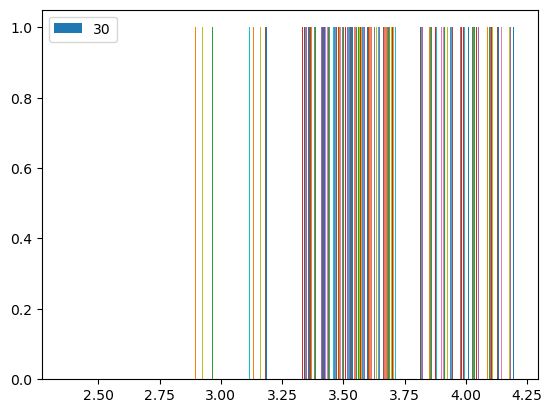

In [14]:
per_label_index = 2
per_label = per_label_array[per_label_index]
print("For per-label - " + str(per_label))
temp = torch.flatten(min_threat[per_label_index], start_dim=0).cpu()
print(temp.shape)
print(torch.min(temp))
print(torch.max(temp))
print(torch.mean(temp))
plt.hist(temp, bins=4, label=str(per_label))
plt.legend()

/cis/home/rmuthuk1/anaconda3/envs/advrob/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


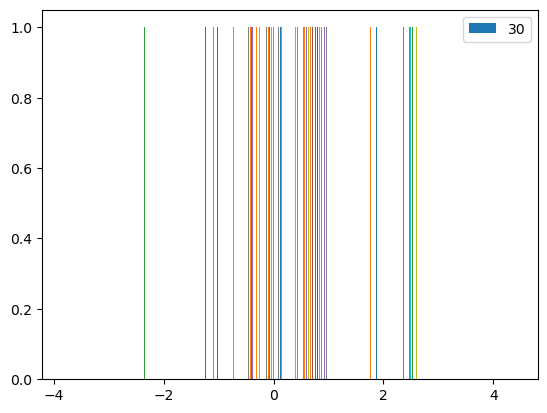

In [15]:
plt.hist(torch.randn(10000), bins=10, label=str(per_label))
plt.legend()

In [ ]:
overall_threat[0][0][0]

In [ ]:
for per_label_index in range(len(per_label_array)):
    torch.flatten(relative_diff, start_dim=)

In [ ]:
def compare_threat():
    for label1 in range(num_labels):
        print("At label1 " + str(label1))

        # a = load_class_partition(train=False, label=label1)
        a = test_class_partition[label1]
        a = move_to_device(a, cuda)

        torch.cuda.empty_cache()

        for label2 in range(num_labels):
            if label2 == label1:
                continue

            # b = load_class_partition(train=False, label=label2)
            b = test_class_partition[label2]
            b = move_to_device(b, cuda)

            torch.cuda.empty_cache()

            for label3 in range(num_labels):
                if label3 == label1:
                    continue

                # c = load_class_partition(train=True, label=label3)
                c = train_class_partition[label3]
                # c = load_class_partition(train=True, greedy=True, label=label3, num_points=5000)
                # c = greedy_train_class_partition[label3]
                c = move_to_device(c, cuda)

                del c
            del b
        del a
        torch.cuda.empty_cache()


In [ ]:
for label1 in range(num_labels):
    print("At label1 " + str(label1))

    # a = load_class_partition(train=False, label=label1)
    a = test_class_partition[label1]
    a = move_to_device(a, cuda)

    torch.cuda.empty_cache()

    for label2 in range(num_labels):
        if label2 == label1:
            continue

        # b = load_class_partition(train=False, label=label2)
        b = test_class_partition[label2]
        b = move_to_device(b, cuda)

        torch.cuda.empty_cache()

        for label3 in range(num_labels):
            if label3 == label1:
                continue

            # c = load_class_partition(train=True, label=label3)
            c = train_class_partition[label3]
            # c = load_class_partition(train=True, greedy=True, label=label3, num_points=5000)
            # c = greedy_train_class_partition[label3]
            c = move_to_device(c, cuda)

            del c
        del b
    del a
    torch.cuda.empty_cache()
    

In [ ]:
# misspecification 

# threat comparison 

In [ ]:
#for label in range(200):
    #train_str = "./tiny-imagenet-200/train/train_class_partition_" + str(label) + ".pt"
    #test_str = "./tiny-imagenet-200/test/test_class_partition_" + str(label) + ".pt"
    #train_cp = torch.load(train_str)
    #test_cp = torch.load(test_str)

In [ ]:
del train_cp_loaders, test_cp_loaders

In [ ]:
input1 = test_image_partition[13][0]

input1.shape

In [ ]:
len(train_image_partition[13])

In [ ]:
for images in train_cp_loaders[10]:
    images = move_to_device(images, cuda)
    print(images.shape)
    diff1 = input1.unsqueeze(0)
    diff1 = images-input1
    print(diff1.shape)
    diff2 = torch.zeros_like(images)
    for index in range(len(images)):
        diff2[index] = images[index]-input1
    
    print(diff2.shape)

    print(torch.linalg.norm(torch.flatten(diff1-diff2, start_dim=0), ord=2))
    # so diff1 and diff2 are the same
    diff1 = torch.flatten(diff1, start_dim=1)
    print('flat shape is ' + str(diff1.shape))
    norms = torch.linalg.norm(diff1, dim=1, ord=2)
    print(norms.shape)
    break

In [ ]:
val = -0.5
val = val * (val > 0)
print(val)
val < 0.0

In [ ]:
label1 = 13
label2 = 97
label4 = 49
input1 = torch.flatten(test_image_partition[label1],start_dim=1)
print(input1.shape)
input2 = torch.flatten(test_image_partition[label2], start_dim=1)
input4 = torch.flatten(test_image_partition[label4], start_dim=1)
print(input2.shape)

In [ ]:
sum(test_labels % 3 == 1)

In [ ]:
len(test_images[(test_labels != label1) * (test_labels % 3 == 1)])

In [ ]:
a = torch.zeros(4,100)
b = torch.zeros(5,100)
c = - (a.unsqueeze(1) - b)
c.shape

In [ ]:
torch.sum(c[2,3] - (a[2]-b[3]))

In [ ]:
perturbation = -(input1.unsqueeze(1) - input2)
perturbation.shape

In [ ]:
#trainset = TrainTinyImageNetDataset(id=id_dict, transform=transform)
#trainloader2 = torch.utils.data.DataLoader(trainset, batch_size=1024, shuffle=True, num_workers=4)

In [ ]:
label1 = 5
    bel2 = 183
cuda_new = torch.device("cuda:7")
input1 = torch.flatten(test_image_partition[label1], start_dim=1)
input1 = input1.to(device=cuda_new)
print("input1 shape is " + str(input1.shape))
input2 = torch.flatten(
    test_images[(test_labels != label1) * (test_labels % 4 == 0)], start_dim=1
)
input2 = input2.to(device=cuda_new)
print("input2 shape is " + str(input2.shape))
perturbation = -(input1.unsqueeze(1) - input2)
print("perturbation shape is " + str(perturbation.shape))
# batch_distances = torch.zeros((len(input1), len(input2), 12), device=cuda)
# print('batch_distances shape is ' +str(batch_distances.shape))
max_distance = torch.zeros((len(input1), len(input2)), device=cuda_new)

count = 0
for label3 in range(200):
    if label3 % 10 == 0:
        print("Label3 is now " + str(label3))
    # if count > 0:    break
    if label3 == label1:
        continue
    else:
        images3 = move_to_device(
            train_image_partition[label3], cuda_new
        )  # train_image_partition[label3]
        images3 = torch.flatten(images3, start_dim=1)
        unsafe_directions = -(input1.unsqueeze(1) - images3)
        # print("shape of unsafe direction is " + str(unsafe_directions.shape))
        unsafe_norms = torch.linalg.norm(unsafe_directions, dim=2, ord=2) ** 2
        # print("shape of unsafe normalization is " + str(unsafe_norms.shape))
        unsafe_directions = unsafe_directions / unsafe_norms.unsqueeze(-1)

        # print("\nTrying approach 1")
        # print(perturbation.shape)
        # print(unsafe_directions.shape)

        # for index in range(len(input1)):
        #    batch_distances = torch.matmul(
        #        perturbation[index], unsafe_directions[index].T
        #    )
        #    max_distance[index] = torch.maximum(
        #        max_distance[index], torch.max(batch_distances, dim=1).values
        #    )
        #    if index == -1:
        #        print(
        #            "At each index, batch_distances shape is "
        #            + str(batch_distances.shape)
        #        )
        #        print("At each index, max_distance at index shape is " + str(max_distance[index].shape))

        # print("\nTrying approach 2")
        # print(perturbation.shape)
        # print(unsafe_directions.shape)
        batch_distances = torch.bmm(perturbation, unsafe_directions.permute(0, 2, 1))
        max_distance = torch.maximum(
            torch.max(batch_distances, dim=2).values, max_distance
        )
        # print(batch_distances_2.shape)
        # print('flattening')
        # temp1 = torch.flatten(batch_distances, start_dim=0)
        # print(temp1.shape)
        # temp2 = torch.flatten(batch_distances_2, start_dim=0)
        # print(temp2.shape)
        # print(torch.linalg.norm(temp1-temp2, ord=1))
        # del batch_distances, unsafe_directions, unsafe_norms, images3
        count += 1

# max_distance = torch.maximum(max_distance)
# print(max_distance)
# print("max distance until label " + str(label3) + " is " + str(max_distance))

I need multiple gpus lets say 5. 
- For each label gpu. 

measure misspecification and store the values. 
measure threat comparison, store the values. 

In [ ]:
del input1, input2

In [ ]:
300000*1e-7

In [ ]:
del trainset, testset

In [ ]:
n = len(input1)
max_distance = torch.zeros((len(input1), len(input2)), device=cuda)

count = 0
for label3 in range(200):
    if label3 == label1:
        continue
    
    if label3 % 10 == 0:
        print('Label3 is now ' + str(label3))
    #if count > 0: break 

    for images3 in train_cp_loaders[label3]:
        images3 = move_to_device(images3, cuda)
        images3 = torch.flatten(images3, start_dim=1)
        unsafe_directions = -(input1.unsqueeze(1) - images3)
        #print(unsafe_directions.shape)
        unsafe_norms = torch.linalg.norm(unsafe_directions, dim=2, ord=2) ** 2
        #print(unsafe_norms.shape)
        unsafe_directions = unsafe_directions / unsafe_norms.unsqueeze(
            -1
        )  # torch.div(unsafe_directions, unsafe_norms)
        #print("before matmul")
        #print(perturbation.shape)
        #print(unsafe_directions.shape)
        for index in range(len(input1)):
            batch_distances = torch.matmul(perturbation[index], unsafe_directions[index].T)
            #print(batch_distances.shape)
            max_distance[index] = torch.maximum(max_distance[index], torch.max(batch_distances, dim=1).values)
            #print(batch_max_distance.shape)
            #print(batch_max_distance)
            #max_distance[index] = batch_max_distance * (batch_max_distance > 0)
            #print('the distances are now ')
            #print(max_distance[index])
        #print("did it work?")
        #batch_max_distance = torch.max(batch_distances).item()
        #batch_max_distance = batch_max_distance * (batch_max_distance > 0)
        #print(batch_max_distance)
        #max_distance = max(batch_max_distance, max_distance)
        count += 1

print(max_distance)
#print("max distance until label " + str(label3) + " is " + str(max_distance))

In [ ]:
min_max_distance_ft = torch.min(max_distance, dim=1).values.cpu().numpy()

np.shape(min_max_distance_ft)

In [ ]:
min_max_distance_ft

In [ ]:
len(min_max_distance_ft[min_max_distance_ft < 0.7])*100/len(min_max_distance_ft)

In [ ]:
plt.hist(min_max_distance_ft, bins=5)

In [ ]:
max_distance_ft = torch.flatten(max_distance, start_dim=0).cpu().numpy()

In [ ]:
len(max_distance_ft[max_distance_ft < 0.7])*100/len(max_distance_ft)

In [ ]:
2.16*2500/100

In [ ]:
plt.hist(max_distance_ft, bins=20)

In [ ]:
print(label_dict[89])
print(label_dict[90])

In [ ]:
max_distance_ft = torch.flatten(max_distance, start_dim=0).cpu().numpy()
print(len(max_distance_ft[max_distance_ft < 1.0]) * 100 / len(max_distance_ft))
plt.hist(max_distance_ft, bins=20)

In [ ]:
len(max_distance_ft)

In [ ]:
print(len(max_distance_ft[max_distance_ft < 0.6]) * 100 / len(max_distance_ft))


In [ ]:
count = 0
label1 = 13
label2 = 49

for index1 in range(len(test_image_partition[label1])):
    if count != 0:
        break

    input1 = test_image_partition[label1][index1]

    for index2 in range(len(test_image_partition[label2])):
        if count != 0:
            break

        input2 = test_image_partition[label2][index2]
        perturbation = torch.flatten(input2 - input1, start_dim=0).T
        print("Perturbation shape is " + str(perturbation.shape))

        max_distance = 0.0

        for label3 in range(200):
            # if count != 0:
            #    break

            if label3 == label1:
                continue

            for images3 in train_cp_loaders[label3]:
                images3 = move_to_device(images3, cuda)
                unsafe_directions = torch.flatten(
                    images3 - input1.unsqueeze(0), start_dim=1
                )
                # print(unsafe_directions.shape)
                unsafe_norms = torch.linalg.norm(unsafe_directions, dim=1, ord=2) ** 2
                unsafe_directions = unsafe_directions / unsafe_norms.unsqueeze(
                    -1
                )  # torch.div(unsafe_directions, unsafe_norms)
                # print(unsafe_directions.shape)
                batch_distances = torch.matmul(unsafe_directions, perturbation)
                batch_max_distance = torch.max(batch_distances).item()
                batch_max_distance = batch_max_distance * (batch_max_distance > 0)
                print(batch_max_distance)
                max_distance = max(batch_max_distance, max_distance)
                count += 1

            print(
                "max distance until label " + str(label3) + " is " + str(max_distance)
            )


# overall count should be 10000/50 x 10000/50 x 1000000/100 : 10^4 x 10^4 x 10^6 / 100*2500 = 10^14 / (10^4 x 25) = 10^10/25 = 10^9/2.5 = 4 x 10^8
# 4 x 10^8/10^3 = 400,000
# for images, labels in testloader:
#    if count != 0 and count % 1e3 == 0:
#        break
#    for images2, labels2 in testloader:
#        for label3 in range(200):
#            for images3 in train_cp_loaders[label3]:
#                # unsafe_directions = images3-images1
#                count += 1

In [ ]:
count

In [ ]:
train_cp_loaders[0]

In [ ]:
count = 0

# create max distance array of 200 x 50 x 200 x 50 nah this is 100million
for label1 in range(200):
    print("Label1 is at " + str(label1))

    for images1 in test_cp_loaders[label1]:
        # shape of images 1 is 50*3*64*64
        # maintain max_distance for each image 50*1

        for label2 in range(200):
            if label2 == label1:
                continue

            for images2 in test_cp_loaders[label2]:
                # shape of images 2 is 50x3x64x64

                perturbation = torch.flatten(images2 - images1, start_dim=0)

                # i need perturbations to be a tensor of size num(images1) x num(images2) x 3 x 64 x 64
                # so perturbations[i,j] is the difference between images2[j] - images1[i]
                # flatten perturbations so that perturbations[i,j] is 12288 length 1D tensor 
                # now for each of these perturbations the source image had label - label1. 
                # i need perturbations to be a tensor of size 50 x 50 x 3 x 64 x 64 that's 30 million!

                for label3 in range(200):
                    if label3 == label1:
                        continue

                    for images3 in train_cp_loaders[label3]:
                        unsafe_directions = torch.flatten(images3-images1, start_dim=
                        norm_diff = torch.linalg.norm(unsafe_directions)
                        u_index = (label//int(label_stride)) * per_label + index
                        input = selected_domain[label][index]
                        norm_diff = float("inf")
                        norm_diff = torch.linalg.norm(torch.flatten(input - reference_input, start_dim=0), ord=2)** 2
                        unsafe_dirs[u_index] = (input - reference_input) / norm_diff
                        unsafe_normalization[index] = torch.sqrt(norm_diff)


                        # i need unsafe directions of num(images1) x num(images3) x 3 x 64 x 64
                        # so unsafe[i,k] is the difference between images3[k] - images1[i]
                        # flatten unsafe so that unsafe[i,k] is 12288 length 1D tensor
                        # create distance matrix out of perturbations[i,j] unsafe[i,k]
                        count += 1

count

In [ ]:
label = 89
num = 4
base = torch.randint(0, 500-num-1, (1,)).item()
img_select = train_image_partition[label][base:base+num]
for i in range(num):
    img_min = img_select[i].min()
    img_max = img_select[i].max()
    img_select[i].clamp_(min=img_min, max=img_max)
    img_select[i].add_(-img_min).div_(img_max - img_min + 1e-5)
img = torchvision.utils.make_grid(img_select, nrow=num)
plt.figure(figsize=(12, 12))
plt.imshow(img.cpu().permute(1, 2, 0))

In [ ]:
label = 89
num = 4
base = torch.randint(0, 50 - num - 1, (1,)).item()
#print(base)
#print(base + num)
#print(len(test_image_partition[label][base : base + num]))
img_select = test_image_partition[label][base : base + num]
#print(img_select.shape)
for i in range(num):
    img_min = img_select[i].min()
    img_max = img_select[i].max()
    img_select[i].clamp_(min=img_min, max=img_max)
    img_select[i].add_(-img_min).div_(img_max - img_min + 1e-5)
img = torchvision.utils.make_grid(img_select, nrow=num)
plt.figure(figsize=(12, 12))
plt.imshow(img.cpu().permute(1, 2, 0))

In [ ]:
def get_greedy_subset_partition(domain, num_points):
    #print(list(domain.size()))
    inp_shape = list(domain.shape)[1:]
    subset_shape = [num_points] + inp_shape
    rand_index = torch.randint(0,len(domain), (1,)).item()
    subset_domain = torch.zeros(subset_shape, device=cuda)
    subset_labels = torch.zeros(num_points, dtype=torch.int64, device=cuda)
    subset_domain[0] = domain[rand_index]
    
    domain_flat = torch.flatten(domain, start_dim=1)
    for index in range(1, num_points):
        sim = pairwise_cosine_similarity(domain_flat, torch.flatten(subset_domain[:index], start_dim=1))
        max_sim = torch.max(sim, dim=1).values
        selected_index = torch.argmin(max_sim).item()
        subset_domain[index] = domain[selected_index]
    return subset_domain   

def get_greedy_class_subset(domain_partition, num_points):
    greedy_train_image_partition = dict()
    for label in range(200):
        if label%50 == 0:
            print('Finding greedy partition for label ' + str(label))
        greedy_train_image_partition[label] = get_greedy_subset_partition(domain_partition[label], num_points//200)
    return greedy_train_image_partition 

In [ ]:
len(test_image_partition[0])

In [ ]:
def compute_unsafe_dir(reference_input, reference_label, selected_domain, beta=1.0, label_stride=None):
    per_label = len(selected_domain[0])
    num_labels = len(selected_domain)
    #print("Inside compute unsafe and number of labels is " + str(num_labels))
    num = num_labels * per_label #+ 1 
    inp_shape = list(reference_input.shape)

    unsafe_dirs = torch.zeros([num] + inp_shape, device=cuda)
    unsafe_normalization = torch.ones(num, device=cuda) * float("inf")

    for label in range(200):
        if label_stride is not None and label % int(label_stride) != 0:
            continue

        for index in range(per_label):
            u_index = (label//int(label_stride)) * per_label + index
            input = selected_domain[label][index]
            norm_diff = float("inf")
            if label != reference_label:
                norm_diff = (
                    beta
                    * torch.linalg.norm(
                        torch.flatten(input - reference_input, start_dim=0), ord=2
                    )
                    ** 2
                )
                unsafe_dirs[u_index] = (input - reference_input) / norm_diff
                unsafe_normalization[index] = torch.sqrt(norm_diff)

    #ref_norm = (
    #    torch.linalg.norm(torch.flatten(reference_input, start_dim=0), ord=2) ** 2
    #)
    #unsafe_dirs[-1] = -reference_input / ref_norm
    #unsafe_normalization[-1] = torch.sqrt(ref_norm)

    return unsafe_dirs, unsafe_normalization

In [ ]:
def compare_threats(data_size, domain, test_domain, label_stride=None):
    print("Label stride is " + str(label_stride))
    num_label = len(domain)
    per_label = len(domain[0])
    half_per_label = int(0.5 * per_label)
    data_per_label = data_size // num_label
    print("Data per label is " + str(data_per_label))
    assert data_per_label < int(half_per_label)

    test_per_label = len(test_domain[0])

    domain_first_half = dict()
    domain_second_half = dict()

    random_index = 0  # torch.randint(0, half_per_label - data_per_label, (1,)).item()

    active_labels = []
    for label in range(num_label):
        if label_stride is not None and label % int(label_stride) == 0:
            active_labels.append(label)
    print("Active labels are ")
    print(active_labels)

    for label in range(num_label):
        if label_stride is not None and label % int(label_stride) != 0:
            continue

        domain_first_half[label] = domain[label][
            random_index : random_index + data_per_label
        ]
        domain_second_half[label] = domain[label][
            half_per_label
            + random_index : half_per_label
            + random_index
            + data_per_label
        ]

    # subset_first_half = get_greedy_class_subset(domain_first_half, data_size//2)
    # subset_second_half = get_greedy_class_subset(domain_second_half, data_size//2)

    all_overall_diff = []
    count = 0
    overall_diff = 0.0
    max_diff = 0.0
    avg_threat = 0.0
    all_threat_first_half = []
    all_threat_second_half = []

    for label_1 in range(num_label):
        if label_stride is not None and label_1 % int(label_stride) != 0:
            continue

        # print("evaluating threats for label_1 " + str(label_1))

        for index_1 in range(test_per_label):
            # if label_1 % 50 == 0 and index_1 % 10 == 0: print('evaluating threats for index_1 ' + str(index_1))
            input_1 = test_domain[label_1][index_1]
            (
                unsafe_dirs_first_half,
                _
            ) = compute_unsafe_dir(
                input_1, label_1, domain_first_half, beta=1.0, label_stride=label_stride
            )
            (
                unsafe_dirs_second_half,
                _
            ) = compute_unsafe_dir(
                input_1,
                label_1,
                domain_second_half,
                beta=1.0,
                label_stride=label_stride,
            )

            unsafe_ft_first_half = torch.flatten(unsafe_dirs_first_half, start_dim=1)
            unsafe_ft_second_half = torch.flatten(unsafe_dirs_second_half, start_dim=1)

            for label_2 in range(num_label):
                if label_1 == label_2:
                    continue

                if label_stride is not None and label_2 % int(label_stride) != 0:
                    continue

                for index_2 in range(test_per_label):
                    input_2 = test_domain[label_2][index_2]
                    perturbation = torch.flatten(input_2 - input_1, start_dim=0).T
                    distances_first_half = torch.matmul(
                        unsafe_ft_first_half, perturbation
                    )
                    max_distance_first_half = torch.max(distances_first_half).item()

                    distances_second_half = torch.matmul(
                        unsafe_ft_second_half, perturbation
                    )
                    max_distance_second_half = torch.max(distances_second_half).item()

                    assert not torch.isnan(distances_second_half).any()
                    assert not torch.isnan(distances_first_half).any()

                    count += 1
                    all_threat_first_half.append(max_distance_first_half)
                    all_threat_second_half.append(max_distance_second_half)
                    distance_diff = abs(
                        max_distance_first_half - max_distance_second_half
                    )
                    distance_sum = max_distance_first_half + max_distance_second_half
                    distance_max = max(
                        max_distance_first_half, max_distance_second_half
                    )
                    if max_diff < distance_diff:
                        max_diff = distance_diff
                    relative_distance_diff = distance_diff / distance_max
                    overall_diff += relative_distance_diff
                    all_overall_diff.append(relative_distance_diff)
                    avg_threat += distance_sum

                del unsafe_dirs_first_half, unsafe_dirs_second_half, unsafe_ft_first_half, unsafe_ft_second_half

    overall_diff = overall_diff / count
    avg_threat = avg_threat / (2 * count)
    print("Comparison Experiment with " + str(data_size) + " data points")
    print("Average threat is " + str(avg_threat))
    print("Average threat difference is " + str(overall_diff))
    print("Max threat difference is " + str(max_diff))
    print("\n")
    # Plotting a basic histogram
    plt.figure()
    plt.hist(all_overall_diff, bins=15, color="skyblue", edgecolor="black")
    plt.axvline(overall_diff, color="green", linestyle="dashed", linewidth=2)
    # Adding labels and title
    plt.xlabel("Relative Threat Difference")
    plt.ylabel("Frequency")
    plt.title("Histogram of Relative Threat for " + str(data_size) + " data points")
    plt.savefig("relative_threat_" + str(data_size) + ".pdf")
    return (
        overall_diff,
        max_diff,
        avg_threat,
        all_overall_diff,
        all_threat_first_half,
        all_threat_second_half,
    )

In [ ]:
torch.linspace(500, 45000, 10, dtype=int)

In [ ]:
data_size_array = torch.linspace(40000, 48000, 10, dtype=int)
print(data_size_array)

label_stride = 1

active_labels = []
for label in range(200):
    if label % label_stride == 0:
        active_labels.append(label)
print(active_labels)
print('Number of active labels - ' + str(len(active_labels)))

word_active_labels = []
for label in active_labels:
    word_active_labels.append(label_dict[label])
print(word_active_labels)

overall_diff_array = torch.zeros(len(data_size_array))
max_diff_array = torch.zeros(len(data_size_array))
avg_threat_array = torch.zeros(len(data_size_array))
all_overall_diff_array = []
all_overall_threat_first_half = []
all_overall_threat_second_half = []
for index, data_size in enumerate(data_size_array):
    (
        overall_diff_array[index],
        max_diff_array[index],
        avg_threat_array[index], 
        all_overall_diff,
        all_threat_first_half,
        all_threat_second_half
    ) = compare_threats(
        int(data_size.item()), train_image_partition, test_image_partition, label_stride
    )
    all_overall_diff_array.append(all_overall_diff)
    all_overall_threat_first_half.append(all_threat_first_half)
    all_overall_threat_second_half.append(all_threat_second_half)

print(overall_diff_array)
print(max_diff_array)

In [ ]:
len(all_overall_diff_array[0])

In [ ]:
print(len([t for t in all_overall_diff_array[0] if t == 0]))

In [ ]:
all_overall_threat_first_half[0][0:10]

In [ ]:
all_overall_threat_second_half[0][0:10]

In [ ]:
count = 0
same_indices = []
for index in range(len(all_overall_threat_first_half[0])):
    if all_overall_threat_first_half[0][index] == all_overall_threat_second_half[0][index]:
        count += 1
        same_indices.append(index)
print(count)
print(same_indices[:10])

In [ ]:
print(len([t for t in all_overall_threat_first_half[0] if t == 0]))
print(len([t for t in all_overall_threat_second_half[0] if t == 0]))

In [ ]:
active_labels

In [ ]:
percentage_array = np.zeros(len(data_size_array), 100)
percentage_thresholds = torch.logspace(-3,0,100) #torch.linspace(0,1,100)
for index, data_size in enumerate(data_size_array):
    all_overall_diff = all_overall_diff_array[index]
    percentage = []
    for threshold_index in range(100):
        threshold = percentage_thresholds[threshold_index]
        count = 0
        for item in all_overall_diff:
            if item > threshold:
                count += 1
        percentage.append(count/len(all_overall_diff))
    percentage_array.append(percentage)

In [ ]:
count = 0
t = -1
for item in all_overall_diff_array[0]:
    if item > t:
        count += 1
count/len(all_overall_diff_array[0])

In [ ]:
percentage_thresholds

In [ ]:
print(human_format(800))
print(human_format(5800))
print(human_format(45000))

In [ ]:
plt.figure()
for index in range(len(data_size_array)):
    data_label = roundup(data_size_array[index]/len(active_labels), base_index=2)
    data_label_str = human_format(data_label)
    plt.plot(percentage_thresholds, percentage_array[index], label=data_label_str)

plt.title(
    "Fraction of "
    + r"$(x, y)$ and $(\tilde{x}, c)$"
    + " with relative threat larger than threshold"
)
plt.xlabel("Threshold for Relative Threat")
plt.ylabel("Percentage")
plt.legend()
#plt.yscale("log")
#plt.xscale("log")
plt.savefig("percentage_vs_threshold.pdf")

In [ ]:
percentage = []
for index in range(len(avg_threat_array)):
    percentage.append(100*overall_diff_array[index].item()/avg_threat_array[index].item())
print(percentage)

plt.plot(dataset_sizes, percentage, label="Relative difference in Threat")
plt.xlabel('Dataset Size (maximum 1750)')
plt.ylabel('Relative difference in Threat')
#plt.plot(dataset_sizes, overall_diff_array.cpu().numpy(), label="Average Difference in Threat")
#plt.plot(dataset_sizes, avg_threat_array.cpu().numpy(), label="Average Threat")

In [ ]:
active_labels = [0, 30, 60, 90, 120, 150, 180]
word_active_labels = []
for label in active_labels:
    word_active_labels.append(label_dict[label])
print(word_active_labels)

In [ ]:
word_active_labels[3]

In [ ]:
avg_threat_array

In [ ]:
compare_threats(11500, train_image_partition, test_image_partition)

In [ ]:
greedy_train_image_partition = get_greedy_class_subset(train_image_partition, 2500)

In [ ]:
print(2500//200) 
greedy_train_image_partition[0].shape

In [ ]:
label = 156
base = 0
num = 2500//200
col = 3
print(label_dict[label])
img_select = greedy_train_image_partition[label][base:base+num]
for i in range(num):
    img_min = img_select[i].min()
    img_max = img_select[i].max()
    img_select[i].clamp_(min=img_min, max=img_max)
    img_select[i].add_(-img_min).div_(img_max - img_min + 1e-5)
img = torchvision.utils.make_grid(img_select, ncol=col, nrow=num//col)
plt.figure(figsize=(12, 12))
plt.imshow(img.cpu().permute(1, 2, 0))

In [ ]:
a = torch.randn(5,5)
torch.max(a, dim=1).indices

In [ ]:
min_train_scores_all_class = torch.ones(200,200, device=cuda)*float('inf')
avg_train_scores_all_class = torch.ones(200,200, device=cuda)*float('inf')
minimum_train_label = torch.ones(200, device=cuda)
minimum_train_idx = (-1, 1)
minimum_train_score = float('inf')
minimum_train_label_pairs = (-1, -1)

min_test_scores_all_class = torch.ones(200,200, device=cuda)*float('inf')
avg_test_scores_all_class = torch.ones(200,200, device=cuda)*float('inf')
minimum_test_label = torch.ones(200, device=cuda)
minimum_test_idx = (-1, 1)
minimum_test_score = float('inf')
minimum_test_label_pairs = (-1, -1)

for label in range(200):
    train_images_ft = torch.flatten(train_image_partition[label], start_dim=1)
    test_images_ft = torch.flatten(test_image_partition[label], start_dim=1)
    
    for diff_label in range(200):
        if label == diff_label:
            min_train_scores_all_class[label, label] = 1.0
            continue 

        if min_train_scores_all_class[diff_label, label] < float('inf'):
            min_train_scores_all_class[label, diff_label] = min_train_scores_all_class[diff_label, label]
        
        diff_train_images_ft = torch.flatten(greedy_train_image_partition[diff_label], start_dim=1)        
        train_pairwise_scores = pairwise_cosine_similarity(train_images_ft, diff_train_images_ft)
        train_max_pairwise_score_values = torch.max(train_pairwise_scores, dim=1).values
        train_max_pairwise_score_idx = torch.max(train_pairwise_scores, dim=1).indices
        min_train_scores_all_class[label, diff_label] = torch.min(train_max_pairwise_score_values).item()
        avg_train_scores_all_class[label, diff_label] = torch.mean(train_max_pairwise_score_values).item()

        if min_train_scores_all_class[label, diff_label] < minimum_train_score:
            minimum_train_score = min_train_scores_all_class[label, diff_label] 
            minimum_train_label_pairs = (label, diff_label)
            train_id1 = torch.argmin(train_max_pairwise_score_values).item()
            train_id2 = train_max_pairwise_score_idx[train_id1].item()
            minimum_train_idx = (train_id1, train_id2)

        test_pairwise_scores = pairwise_cosine_similarity(test_images_ft, diff_train_images_ft)
        test_max_pairwise_score_values = torch.max(test_pairwise_scores, dim=1).values
        test_max_pairwise_score_idx = torch.max(test_pairwise_scores, dim=1).indices
        min_test_scores_all_class[label, diff_label] = torch.min(test_max_pairwise_score_values).item()
        avg_test_scores_all_class[label, diff_label] = torch.mean(test_max_pairwise_score_values).item()
        
        if min_test_scores_all_class[label, diff_label] < minimum_test_score:
            minimum_test_score = min_test_scores_all_class[label, diff_label] 
            minimum_test_label_pairs = (label, diff_label)
            test_id1 = torch.argmin(test_max_pairwise_score_values).item()
            test_id2 = test_max_pairwise_score_idx[test_id1].item()
            minimum_test_idx = (test_id1, test_id2)
            
print('minimum train score is ' + str(minimum_train_score))
print('minimum training score is achieved by label pair - ' + str(minimum_train_label_pairs))
print('minimum training score is achieved by input idx - ' + str(minimum_train_idx))
print('\n')
print('minimum test score is ' + str(minimum_test_score))
print('minimum test score is achieved by label pair - ' + str(minimum_test_label_pairs))
print('minimum test score is achieved by input idx - ' + str(minimum_test_idx))


In [ ]:
print(label_dict[140])
print(label_dict[156])
print(label_dict[72])

In [ ]:
min_test_scores_all_class[100]

In [ ]:
avg_test_scores_all_class[100]

In [ ]:
min_train_scores_all_class = torch.ones(200,200, device=cuda)*float('inf')
minimum_train_label = torch.ones(200, device=cuda)
minimum_train_idx = (-1, 1)
minimum_train_score = float('inf')
minimum_train_labels = (-1, -1)

min_test_scores_all_class = torch.ones(200,200, device=cuda)*float('inf')
minimum_test_label = torch.ones(200, device=cuda)
minimum_test_idx = (-1, 1)
minimum_test_score = float('inf')
minimum_test_labels = (-1, -1)

for label in range(200):
    train_images_ft = torch.flatten(train_image_partition[label], start_dim=1)
    test_images_ft = torch.flatten(test_image_partition[label], start_dim=1)
    for diff_label in range(200):
        greedy_train_images_ft = torch.flatten(greedy_train_image_partition[diff_label], start_dim=1)
        train_pairwise_scores = pairwise_cosine_similarity(train_images_ft, greedy_train_images_ft)
        train_max_pairwise_score_values = torch.max(train_pairwise_scores, dim=1).values
        train_max_pairwise_score_idx = torch.max(train_pairwise_scores, dim=1).indices
        min_train_scores_all_class[label, diff_label] = torch.min(train_max_pairwise_score_values).item()
        
        if min_train_scores_all_class[label, diff_label] < minimum_train_score:
            minimum_train_score = min_train_scores_all_class[label, diff_label] 
            minimum_train_labels = (label, diff_label)
            train_id1 = torch.argmin(train_max_pairwise_score_values).item()
            train_id2 = train_max_pairwise_score_idx[train_id1].item()
            minimum_train_idx = (train_id1, train_id2)

        test_pairwise_scores = pairwise_cosine_similarity(test_images_ft, greedy_train_images_ft)
        test_max_pairwise_score_values = torch.max(test_pairwise_scores, dim=1).values
        test_max_pairwise_score_idx = torch.max(test_pairwise_scores, dim=1).indices
        min_test_scores_all_class[label, diff_label] = torch.min(test_max_pairwise_score_values).item()
        
        if min_test_scores_all_class[label, diff_label] < minimum_test_score:
            minimum_test_score = min_test_scores_all_class[label, diff_label] 
            minimum_test_labels = (label, diff_label)
            test_id1 = torch.argmin(test_max_pairwise_score_values).item()
            test_id2 = test_max_pairwise_score_idx[test_id1].item()
            minimum_test_idx = (test_id1, test_id2)
            
print('minimum train score is ' + str(minimum_train_score))
print('minimum training score is achieved by label pair - ' + str(minimum_train_labels))
print('minimum training score is achieved by input idx - ' + str(minimum_train_idx))
print('\n')
print('minimum test score is ' + str(minimum_test_score))
print('minimum test score is achieved by label pair - ' + str(minimum_test_labels))
print('minimum test score is achieved by input idx - ' + str(minimum_test_idx))


In [ ]:

print(unsafe_dirs.shape)

In [ ]:
print(reference_input.shape)

In [ ]:
torch.flatten(unsafe_dirs, start_dim=1).shape

In [ ]:

perturbation = train_image_partition[alt_label] - reference_input
perturbation.shape

In [ ]:
torch.max(torch.mm(torch.flatten(unsafe_dirs, start_dim=1), torch.flatten(perturbation, start_dim=1).T), dim=0).values.shape

In [ ]:
#alt_input = torch.randn(3, 64, 64, device=cuda)*0.5 + reference_input 
reference_input_index = 150
reference_label = 42
alt_label = 49
alt_input_index = 20

reference_input = train_image_partition[reference_label][reference_input_index]
unsafe_dirs, unsafe_normalization = compute_unsafe_dir(reference_input, reference_label, greedy_train_image_partition, beta=1.0)

alt_input = train_image_partition[alt_label][alt_input_index]
current_perturbation = alt_input - reference_input 
unsafe_ft = torch.flatten(unsafe_dirs, start_dim=1)
num_rounds = 10000
epsilon = 0.000001
listp = [] 
listdist = []

for t in range(num_rounds):
    distances = torch.matmul(unsafe_ft, torch.flatten(current_perturbation, start_dim=0).T)
    max_distance = torch.max(distances).item()
    if t % 5000 == 0: 
        print(max_distance)
        listp.append(current_perturbation+reference_input)
        listdist.append(max_distance)
    
    if max_distance <= epsilon:
        print("stopping")
        break
    else:
        unsafe_index = torch.argmax(distances).item()
        u_dir = unsafe_dirs[int(unsafe_index)]
        current_perturbation = current_perturbation - (distances[unsafe_index]-epsilon)*u_dir*unsafe_normalization[i]
    
listp.append(current_perturbation+reference_input)


    

In [ ]:
len(listp)

In [ ]:
listdist

In [ ]:
num_p = len(listp)
list_t_0 = torch.zeros(num_p, 3, 64, 64, device=cuda)
list_t_0[0] = reference_input
z_norms_0 = []
max_d_0 = [] 

for i in range(1,num_p):
    list_t_0[i] = listp[num_p-1-i]
    
for i in range(num_p):
    pert = list_t_0[i] - reference_input
    z_norms_0.append(torch.linalg.norm(torch.flatten(pert, start_dim=0),ord=2).item())
    distances = torch.matmul(unsafe_ft, torch.flatten(pert, start_dim=0).T)
    max_d_0.append(torch.max(distances).item())

for i in range(num_p):
    img_min = list_t_0[i].min()
    img_max = list_t_0[i].max()
    list_t_0[i].clamp_(min=img_min, max=img_max)
    list_t_0[i].add_(-img_min).div_(img_max - img_min + 1e-10)
img = torchvision.utils.make_grid(list_t_0, nrow=10, ncol=5)
print(listdist.reverse())
plt.figure(figsize=(12, 12))
plt.imshow(img.cpu().permute(1, 2, 0))
print(label_dict[reference_label])
print(label_dict[alt_label])
print(z_norms_0)
print(max_d_0)

In [ ]:
num_p = len(listp)
list_t_1 = torch.zeros(num_p, 3, 64, 64, device=cuda)
list_t_1[0] = reference_input
z_norms_1 = []
max_d_1 = []

for i in range(1,num_p):
    list_t_1[i] = reference_input + i/num_p*(alt_input - reference_input) 

for i in range(num_p):
    pert = list_t_1[i] - reference_input
    z_norms_1.append(torch.linalg.norm(torch.flatten(pert, start_dim=0),ord=2).item())
    distances = torch.matmul(unsafe_ft, torch.flatten(pert, start_dim=0).T)
    max_d_1.append(torch.max(distances).item())

for i in range(num_p):
    img_min = list_t_1[i].min()
    img_max = list_t_1[i].max()
    list_t_1[i].clamp_(min=img_min, max=img_max)
    list_t_1[i].add_(-img_min).div_(img_max - img_min + 1e-10)
img = torchvision.utils.make_grid(list_t_1, nrow=10, ncol=5)
plt.figure(figsize=(12, 12))
plt.imshow(img.cpu().permute(1, 2, 0))
print(label_dict[reference_label])
print(label_dict[alt_label])
print(z_norms_1)
print(max_d_1)


In [ ]:
print(linalg.norm())

In [ ]:
num_p = len(listp)
list_t_2 = torch.zeros(num_p, 3, 64, 64, device=cuda)
z = torch.zeros_like(reference_input)
z_norms_2 = []
max_d_2 = []

x_start = 0 
x_end = 30
y_start = 30
y_end = 64

list_t_2[0] = reference_input
for i in range(1,num_p):
    list_t_2[i] = reference_input 
    list_t_2[i][:, x_start:int((2*i)/num_p*x_end), y_start:int((2*i)/num_p*y_end)] = 0.3 

for i in range(num_p):
    pert = list_t_2[i] - reference_input
    z_norms_2.append(torch.linalg.norm(torch.flatten(pert, start_dim=0),ord=2).item())
    distances = torch.matmul(unsafe_ft, torch.flatten(pert, start_dim=0).T)
    max_d_2.append(torch.max(distances).item())

for i in range(num_p):
    img_min = list_t_2[i].min()
    img_max = list_t_2[i].max()
    list_t_2[i].clamp_(min=img_min, max=img_max)
    list_t_2[i].add_(-img_min).div_(img_max - img_min + 1e-10)
img = torchvision.utils.make_grid(list_t_2, nrow=10, ncol=5)
plt.figure(figsize=(12, 12))
plt.imshow(img.cpu().permute(1, 2, 0))
print(label_dict[reference_label])
print(label_dict[alt_label])
print(z_norms_2)
print(max_d_2)


In [ ]:
list_a = []
list_a.extend(list_t_0)
list_a.extend(list_t_1)
list_a.extend(list_t_2)
num = len(list_a)
z_norms = z_norms_0 + z_norms_1 + z_norms_2
max_d = max_d_0 + max_d_1 + max_d_2 
indices = [0, 1, 4, 8]
list_new = []
list_new.append(list_a[0])
list_new.append(list_a[1])
list_new.append(list_a[4])
list_new.append(list_a[8])
list_a = list_new 
print(len(list_a))

for i in range(len(list_a)):
    img_min = list_a[i].min()
    img_max = list_a[i].max()
    list_a[i].clamp_(min=img_min, max=img_max)
    list_a[i].add_(-img_min).div_(img_max - img_min + 1e-10)
img = torchvision.utils.make_grid(list_a, nrow=10, ncol=5)
plt.figure(figsize=(12, 12))
plt.imshow(img.cpu().permute(1, 2, 0))
print(label_dict[reference_label])
print(label_dict[alt_label])
print(z_norms)
print(max_d)



In [ ]:
len(max_d)

In [ ]:
num_p = len(listp)
list_t = torch.zeros(num_p, 3, 64, 64, device=cuda)
z = torch.zeros_like(reference_input)
z_norms = []
max_d = []

x_start = 45 
x_end = 60
y_start = 0
y_end = 24

x_start_2 = 0
x_end_2 = 20
y_start_2 = 40
y_end_2 = 64

list_t[0] = reference_input
for i in range(1,num_p):
    list_t[i] = reference_input 
    list_t[i][:, x_start:int((2*i)/num_p*x_end), y_start:int((2*i)/num_p*y_end)] = 0.3 
    list_t[i][:, x_start_2:int((2*i)/num_p*x_end_2), y_start_2:int((2*i)/num_p*y_end_2)] = 0.3 

for i in range(num_p):
    pert = list_t[i] - reference_input
    z_norms.append(torch.linalg.norm(torch.flatten(pert, start_dim=0),ord=2).item())
    distances = torch.matmul(unsafe_ft, torch.flatten(pert, start_dim=0).T)
    max_d.append(torch.max(distances).item())

for i in range(num_p):
    img_min = list_t[i].min()
    img_max = list_t[i].max()
    list_t[i].clamp_(min=img_min, max=img_max)
    list_t[i].add_(-img_min).div_(img_max - img_min + 1e-10)
img = torchvision.utils.make_grid(list_t, nrow=10, ncol=5)
plt.figure(figsize=(12, 12))
plt.imshow(img.cpu().permute(1, 2, 0))
print(label_dict[reference_label])
print(label_dict[alt_label])
print(z_norms)
print(max_d)


In [ ]:
plt.imshow()

In [ ]:
current_perturbation = perturbation 
    for t in range(len(num_rounds)):
        for (u, M) in zip(unsafe_dir, unsafe_normalization):
            if dist_type == 'PL' or dist_type == 'PD':
                distance = torch.sum(torch.mul(u, current_perturbation))/M 
                current_perturbation = current_perturbation - (distance-epsilon)*u
                if dist_type == 'PD':
                    distance = torch.sum(torch.mul(-u, current_perturbation))/M
                    current_perturbation = current_perturbation - (distance-epsilon)*(-u)
            else:
                continue 
        
        distance = non_isotropic_dist(unsafe_dir, unsafe_normalization, current_perturbation, dist_type=dist_type, return_device=device, return_type=None)
        if distance <= epsilon:
            break 
    
    distance = non_isotropic_dist(unsafe_dir, unsafe_normalization, current_perturbation, dist_type=dist_type, return_device=device, return_type=None)
    
    if distance > epsilon:
        scale_flag = True
        current_perturbation *= (epsilon/distance)
  


In [ ]:
min_distance = float('inf')
per_label = len(greedy_train_image_partition[label])
#train_distances = torch.zeros(200, 200, per_label, per_label, device=cuda)
for label in range(200):
    for input_index in range(per_label):
        if label % 25 == 0 and input_index % 10 == 0:
            print("Finding minimum at label - " + str(label) + ' and input ' + str(input_index))
        reference_input = greedy_train_image_partition[label][input_index]
        unsafe_dirs = compute_unsafe_dir(reference_input, label, greedy_train_image_partition, beta=1.0)
        
        unsafe_ft = torch.flatten(unsafe_dirs, start_dim=1)
        for diff_label in range(200):
            if label == diff_label: continue 
            perturbation = greedy_train_image_partition[diff_label] - reference_input
            unsafe_x_perturbation = torch.mm(unsafe_ft, torch.flatten(perturbation, start_dim=1).T)
            distance_per_perturbation = torch.max(unsafe_x_perturbation, dim=0).values
            distance = torch.min(distance_per_perturbation)
            
            if distance < 0.0:
                print('label is ' + str(label))
                print('diff label is ' + str(diff_label))
                print('distance is ' + str(distance))
                break
                
            if distance < min_distance:
                min_distance = distance 


In [ ]:
200*500*200*500

In [ ]:
def compute_unsafe_dir(reference_input, reference_label, selected_domain, selected_labels, classifier = None, beta=0.7):
    assert len(selected_domain) == len(selected_labels)
    
    unsafe_dirs = torch.zeros_like(selected_domain)
    unsafe_normalization = torch.ones(len(selected_domain), device=cuda)*float('inf')
    
    for (index, input) in enumerate(selected_domain):
        norm_diff = torch.linalg.norm(input - reference_input, ord=2)
        unsafe_dirs[index] = (input-reference_input)/norm_diff
            
        if selected_labels[index] != reference_label:
            if classifier is not None: 
                # binary search to compute normalization when the true labeling function is given
                low = 0
                high = 1
                while high - low > 1e-5:
                    alpha = (high + low)/2
                    input_alpha = reference_input + alpha*(input-reference_input)
                    label_alpha = predict_label(classifier, input_alpha)
                    if label_alpha == reference_label:
                        low = alpha
                    else:
                        high = alpha
                alpha = low
                input_alpha = reference_input + alpha*(input-reference_input)
                unsafe_normalization[index] = torch.linalg.norm(input_alpha-reference_input, ord=2)
            else:
                unsafe_normalization[index] = norm_diff*beta 
    
    return unsafe_dirs, unsafe_normalization

In [ ]:
cpu = torch.device("cpu")
cpu

In [ ]:
def non_isotropic_dist(unsafe_dir, unsafe_normalization, perturbation, dist_type='PL', return_device='cpu', return_type=None):
    if dist_type not in ['PL', 'PD', 'WD']:
        raise ValueError('Non-isotropic distance type should be one of PL, PD, WD')
    
    distance = float('inf')
    
    element_wise_mul = torch.mul(unsafe_dir, perturbation)
    
    if dist_type == 'PL' or dist_type == 'PD':
        scaled_projections = torch.div(torch.sum(element_wise_mul, dim=1), unsafe_normalization)
        if dist_type == 'PL':
            distance = torch.max(scaled_projections)
        elif dist_type == 'PD':
            distance = torch.max(torch.abs(scaled_projections))
    
    if dist_type == 'WD':
        unsafe_4_norm = torch.linalg.norm(unsafe_dir, dim=1, ord=4)**2 # 4-norm
        modified_normalization = torch.mul(unsafe_normalization, unsafe_4_norm)
        scaled_distances = torch.div(torch.linalg.norm(element_wise_mul, dim=1, ord=2), modified_normalization)
        distance = torch.max(scaled_distances)
    
    distance = distance.detach().to(device=return_device)
    
    if return_type is not None:
        return distance.numpy()
    else:
        return distance

In [ ]:
def non_isotropic_projection(unsafe_dir, unsafe_normalization, perturbation, epsilon=1.0, dist_type='PL', num_rounds=3):
    if dist_type not in ['PL', 'PD', 'WD']:
        raise ValueError('Non-isotropic distance type should be one of PL, PD, WD')
    
    if dist_type == 'WD':
        raise ValueError('Projection onto WD currently unsupported')
    
    device = perturbation.get_device()
    scale_flag = False 
    current_perturbation = perturbation 
    
    for t in range(len(num_rounds)):
        for (u, M) in zip(unsafe_dir, unsafe_normalization):
            if dist_type == 'PL' or dist_type == 'PD':
                distance = torch.sum(torch.mul(u, current_perturbation))/M 
                current_perturbation = current_perturbation - (distance-epsilon)*u
                if dist_type == 'PD':
                    distance = torch.sum(torch.mul(-u, current_perturbation))/M
                    current_perturbation = current_perturbation - (distance-epsilon)*(-u)
            else:
                continue 
        
        distance = non_isotropic_dist(unsafe_dir, unsafe_normalization, current_perturbation, dist_type=dist_type, return_device=device, return_type=None)
        if distance <= epsilon:
            break 
    
    distance = non_isotropic_dist(unsafe_dir, unsafe_normalization, current_perturbation, dist_type=dist_type, return_device=device, return_type=None)
    
    if distance > epsilon:
        scale_flag = True
        current_perturbation *= (epsilon/distance)
    
    return current_perturbation, scale_flag

In [ ]:
distance_types = ['l2', 'l1', 'linf', 'PL', 'PD', 'WD']

In [ ]:
def latexify_dist(dist_type: str):
    if dist_type == 'l2': return r'$\ell_2$'
    elif dist_type == 'linf': return r'$\ell_{\infty}$'
    elif dist_type == 'l1': return r'$\ell_1$'
    else: return dist_type

def latexify_inp(index: int):
    if index == 0: return r'$x$'
    elif index == 1: return r'$x_1$'
    elif index == 2: return r'$x_2$'
    elif index == 3: return r'$\tilde{x}$'
    
def latexify_h(index):
    if index is None: return r'$h^{\star}$'
    elif index == 1: return r'$h_1$'
    elif index == 2: return r'$h_2$'

In [ ]:
def get_distances(reference_input, reference_label, domain, true_labels, selected_domain = None, selected_labels = None, classifier = None, dist_type='l2'):
    print("Computing " + dist_type + " distances")
    if dist_type not in distance_types:
        raise ValueError('Distance type should be one of l2, l1, linf, PL, PD, WD')
    
    if selected_domain is not None and selected_labels is not None:
        assert len(selected_domain) == len(selected_labels)
        unsafe_dir, unsafe_normalization = compute_unsafe_dir(reference_input, reference_label, selected_domain, selected_labels, classifier=classifier)
    else:
        unsafe_dir, unsafe_normalization = compute_unsafe_dir(reference_input, reference_label, domain, true_labels, classifier=classifier)        
    
    distances = []
    for (index, input) in enumerate(domain):
        if index % 100 == 0:
            clear_output(wait=True)
            print("Computing distances at index: " + str(index) +  ", out of " + str(len(domain) - 1) + " points.")
        perturbation = input - reference_input
        if dist_type == 'l2':
            distance = torch.linalg.norm(perturbation, ord=2).detach().cpu().numpy()
        elif dist_type == 'l1':
            distance = torch.linalg.norm(perturbation, ord=1).detach().cpu().numpy()
        elif dist_type == 'linf':
            distance = torch.linalg.norm(perturbation, ord=float('inf')).detach().cpu().numpy()
        elif dist_type in ['PL', 'PD', 'WD']:
            distance = non_isotropic_dist(unsafe_dir, unsafe_normalization, perturbation, dist_type)
        distances.append(distance)
    return distances

def sublevel_set(selected_domain, distances, threshold):
    sublevel = []
    for input, distance in zip(selected_domain, distances):
        if distance <= threshold:
            sublevel.append(input.detach().cpu().numpy())
    return sublevel

In [ ]:
l_keys = subset_domain_class.keys()
print(len(l_keys))

In [ ]:
l_keys_list = list(l_keys)

In [ ]:
l_keys_list[0]

In [ ]:
subset_domain_class[l_keys_list[0]].shape

In [ ]:
for i in range(2):
    print(i)

In [ ]:
def generate_distances(reference_domain, reference_labels, domain, true_labels, classifier=h_star, distance_types=distance_types, greedy_subset=False, num_points=100):
    selected_domain = None 
    selected_labels = None 
    
    if greedy_subset:
        num_labels = len(torch.unique(true_labels))
        subset_domain_class = get_greedy_class_subset(domain, true_labels, num_labels, num_points)
        inp_shape = list(domain.shape)[1:]
        selected_domain_shape = [num_points] + inp_shape
        selected_domain = torch.zeros(selected_domain_shape, device=cuda)
        selected_labels = torch.ones(num_points, device=cuda)
        label_keys = list(subset_domain_class.keys())
        increment = num_points//num_labels
        for label_index in range(len(label_keys)):
            selected_domain[label_index*increment:(label_index+1)*increment] = subset_domain_class[label_keys[label_index]]
            selected_labels[label_index*increment:(label_index+1)*increment] *= label_keys[label_index]

    distances = dict()
    for dist_type in distance_types:
        if greedy_subset and dist_type not in ['PL', 'PD', 'WD']:
            continue 
                
        for index in range(len(reference_domain)):
            key = "x" + str(index) + "_" + dist_type
            if greedy_subset:
                key += "_greedy_" + str(num_points)
            
            distances[key] = get_distances(reference_domain[index], reference_labels[index], domain, true_labels, selected_domain=selected_domain, selected_labels=selected_labels, classifier=classifier, dist_type=dist_type)
    
    return distances, selected_domain, selected_labels        

In [ ]:
greedy_distances, selected_domain, selected_labels = generate_distances(reference_domain, reference_labels, domain, true_labels, greedy_subset=True, num_points=20)

In [ ]:
greedy_distances.keys()

In [ ]:
def plot_distance_intensity(corners, reference_points, distances, domain, selected_domain=None, distance_types=distance_types, greedy_subset=False, num_points=100):
    x0, x1, x2, xtil = reference_points[0], reference_points[1], reference_points[2], reference_points[3]
    x_left, y_left, x_right, y_right, x_down, y_down, x_up, y_up = generate_data_domain(corners)
    x, y_star, y_1, y_2 = generate_decision_boundary(corners)
    
    domain_np = domain.cpu().numpy()
    domain_x = [d[0] for d in domain_np]
    domain_y = [d[1] for d in domain_np]
    
    for dist_type in distance_types:
        if greedy_subset and dist_type not in ['PL', 'PD', 'WD']:
            continue 
        
        for index in range(len(reference_points)):
            key = "x" + str(index) + "_" + dist_type
            if greedy_subset:
                key += "_greedy_" + str(num_points)
            
            distance_domain = distances[key]
            plt.figure()
            title_str = latexify_dist(dist_type) + " threat "
            title_str += " from reference point " + latexify_inp(index)
            plt.title(title_str)
            
            # plot the data domain
            plt.plot(x_left, y_left, color="black", linewidth=3)
            plt.plot(x_right, y_right, color="black", linewidth=3)
            plt.plot(x_down, y_down, color="black", linewidth=3)
            plt.plot(x_up, y_up, color="black", linewidth=3)
    
            # plot true labeling decision boundary 
            plt.plot(x, y_star, label=r'$h^{\star}$', linewidth=3)
        
            # plot reference points
            plt.plot(x0[0], x0[1], color="black", marker=latexify_inp(0), markersize=9)
            plt.plot(x1[0], x1[1], color="black", marker=latexify_inp(1), markersize=12)
            plt.plot(x2[0], x2[1], color="black", marker=latexify_inp(2), markersize=12)
            plt.plot(xtil[0], xtil[1], color='black', marker=latexify_inp(3), markersize=12)
            
            # Plot the distance intensity map
            plt.scatter(domain_x, domain_y, c=distance_domain, s=2, cmap="plasma")
            plt.colorbar(orientation='horizontal')
            
            if selected_domain is not None:
                selected_np = selected_domain.cpu().numpy()
                selected_x = [d[0] for d in selected_np]
                selected_y = [d[1] for d in selected_np]
                plt.scatter(selected_x, selected_y, color="black", s=5)
    
            
            plt.axis('off')
            plt.savefig("./distance_intensity_" + key + ".pdf", bbox_inches='tight')

In [ ]:
plot_distance_intensity(corners, reference_points, greedy_distances, domain, selected_domain=selected_domain, greedy_subset=True, num_points=20)   

In [ ]:
# Compute certified threshold for a given point based on its distances matrix and the collection of all points. 
def compute_certified_threshold(reference_domain, reference_labels, domain, true_labels, distances):
    certified_thresholds = dict()
    for dist_type in distance_types:
        for r_index in range(len(reference_domain)):
            key = "x" + str(r_index) + "_" + dist_type
            reference_label = reference_labels[r_index]
            threshold = float('inf')
            for index in range(len(domain)):
                if true_labels[index] != reference_label and threshold > distances[key][index]:
                    threshold = distances[key][index]
            certified_thresholds[key] = threshold
    return certified_thresholds

In [ ]:
reference_labels_h1 = predict_label(h_1, reference_domain)
reference_labels_h2 = predict_label(h_2, reference_domain)

domain_labels_h1 = predict_label(h_1, domain)
domain_labels_h2 = predict_label(h_2, domain)

certified_thresholds_hstar = compute_certified_threshold(reference_domain, reference_labels, domain, true_labels, distances)
certified_thresholds_h1 = compute_certified_threshold(reference_domain, reference_labels_h1, domain, domain_labels_h1, distances)
certified_thresholds_h2 = compute_certified_threshold(reference_domain, reference_labels_h2, domain, domain_labels_h2, distances)

In [ ]:
str(certified_thresholds_hstar['x0_PL'])

In [ ]:
latexify_h(None)

In [ ]:
latexify_dist('l2')

In [ ]:
latexify_inp(0)

In [ ]:
def plot_sublevel_sets(corners, reference_points, distances, domain, certified_thresholds, distance_types=distance_types, h_index=None):
    x0, x1, x2, xtil = reference_points[0], reference_points[1], reference_points[2], reference_points[3]
    x_left, y_left, x_right, y_right, x_down, y_down, x_up, y_up = generate_data_domain(corners)
    x, y_star, y_1, y_2 = generate_decision_boundary(corners)
    h_str = "h" + str(h_index) if h_index is not None else "hstar"
            
    domain_np = domain.cpu().numpy()
    domain_x = [d[0] for d in domain_np]
    domain_y = [d[1] for d in domain_np]
    
    for dist_type in distance_types:
        for index in range(len(reference_points)):
            key = "x" + str(index) + "_" + dist_type
            distance_domain = distances[key]
            certified_threshold = certified_thresholds[key]
            cert_str = "%.2f" % certified_threshold 
            title_str = latexify_dist(dist_type) + " certified threshold for " + latexify_h(h_index) + " at " + latexify_inp(index) + " is " + cert_str
            plt.figure()
            plt.title(title_str)
            
            # plot the data domain
            plt.plot(x_left, y_left, color="black", linewidth=3)
            plt.plot(x_right, y_right, color="black", linewidth=3)
            plt.plot(x_down, y_down, color="black", linewidth=3)
            plt.plot(x_up, y_up, color="black", linewidth=3)
    
            # plot true labeling decision boundary 
            plt.plot(x, y_star, label=r'$h^{\star}$', linewidth=3)
            
            if h_index == 1:
                plt.plot(x, y_1, color='magenta', label=latexify(h_index), linestyle="dashed")
                plt.fill_between(x, y1=y_1, y2=y_star, color= "magenta", alpha= 0.05, hatch='///')
            elif h_index == 2:
                plt.plot(x, y_2, color='purple', label=latexify(h_index), linestyle="dashed")
                plt.fill_between(x, y1=y_2, y2=y_star, color= "purple", alpha= 0.05, hatch='///')
    
            # plot reference points
            plt.plot(x0[0], x0[1], color="black", marker=r"$x$", markersize=9)
            plt.plot(x1[0], x1[1], color="black", marker=r"$x_1$", markersize=12)
            plt.plot(x2[0], x2[1], color="black", marker=r"$x_2$", markersize=12)
            plt.plot(xtil[0], xtil[1], color='black', marker=r'$\tilde{x}$', markersize=12)
            
            # Plot the sublevel sets upto certified threshold
            epsilons = np.linspace(0, certified_threshold, 5)
            for eps in epsilons: 
                sublevel = sublevel_set(domain, distance_domain, eps)
                sublevel_x = [d[0] for d in sublevel]
                sublevel_y = [d[1] for d in sublevel]
                plt.scatter(sublevel_x, sublevel_y, c='red', s=0.1/(0.1+eps))

            plt.axis('off')
            plt.savefig("./certified threshold_" + h_str + key + ".pdf", bbox_inches='tight')



In [ ]:
plot_sublevel_sets(corners, reference_points, distances, domain, certified_thresholds_hstar, h_index=None)

plot_sublevel_sets(corners, reference_points, distances, domain, certified_thresholds_h1, h_index=1)

plot_sublevel_sets(corners, reference_points, distances, domain, certified_thresholds_h2, h_index=2)
    

In [ ]:
# unsafe_dir, unsafe_normalization = compute_unsafe_dir(p_ref, domain)
# unsafe_pert = []
# for d in unsafe_dir:
#     unsafe_pert.append(sum(p_ref, d))

# unsafe_pert_x = [d.x for d in unsafe_pert]
# unsafe_pert_y = [d.y for d in unsafe_pert]


# sublevel_PL = sublevel_set(domain, distance_domain_PL, 0.0)

# sublevel_PL_x = [d.x for d in sublevel_PL]
# sublevel_PL_y = [d.y for d in sublevel_PL]


# plt.scatter(sublevel_PL_x, sublevel_PL_y, c='green', s=0.1)
# plt.scatter(unsafe_pert_x, unsafe_pert_y, c='red', s=0.1)
# #plt.plot([3.8],[0.9], color='black', marker=r'$x$', markersize=9)
# #plt.plot([2.7],[0.361], color='red', marker=r'$x_1$', markersize=12)
# #plt.plot([1.4],[-0.276], color='red', marker=r'$\tilde{x}$', markersize=12)
# plt.plot([4.94],[0.452], color='red', marker=r'$x_2$', markersize=12)
# plt.plot(x, y, color="black", label="h*", linewidth=3)
# plt.plot(x1,y1, color="black", linewidth=3)
# plt.plot(x2,y2, color="black", linewidth=3)
# plt.plot(x3,y3, color="black", linewidth=3)
# plt.plot(x4,y4, color="black", linewidth=3)
# plt.axis('off')
# plt.title("x + Unsafe Directions")

In [ ]:
checking auth. 

# Things to do

## CodeBase 
- 

## Code Refactor 
- Convert point class to torch vector and have functionality that tensors converts to numpy arrays (and check devices) for plotting 
- Modularize existing code to print all relevant plots and save relevant figures (sublevel sets at p0,p1,p2, p-til)
- Save the data domain as a data set. with a tag of "exact partition"
- Add data-generator code that fixes and samples from grid when asked for "synthetic2D"
- Add data-generator code that does regular data-loading for "MNIST, BlockMNIST, CIFAR-x, Imagenet"
- Add dataset-hyperparams for each. 

## Threat functions 
- Implement isotropic functions
- For each point, compute unsafe directions and exact normalization. 
- Implement non-isotropic threat functions. 

## Synthetic2D
- Choose synthetic h, h1, h2 and data domain. 
- Visualize data domain with points p0, p1, p2 and ptil. 
- Design class-wise marginal input distribution that are tightly concentrated. Sample 500 points for each label. 
- Find certified radius for each triple (h, x, d) w.r.t each d in distance metrics (N, approx-n, k-approx-N), each x in the data domain, and h in {h*, h1,h2} by searching over sublevel sets. 
- Visualize as intensity maps. Show variation between h1 and h2. 

## Observed and k-Observed
- Compute unsafe directions with beta normalization w.r.t all sample points. Add resulting distances as observed-PL. 
- Given any data-set find k-subsets for each class using greedy approximation of cosine similarity. Add resulting distances as k-observed-PL. 
- Choose beta for normalization based on the minimal norm of all observed unsafe directions that are within a kappa threshold in cosine similarity. 
- Run through visualization and certification sequence for PL (if exact), observed-PL and k-observed-PL. 

## Projection
- Given a reference point pref, a new point p, Find projection of p to sublevel set Td(pref, epsilon). 
- Use greedy projection algorithm for each non-isotropic distance. Run T rounds and then scale the iterate if it is still not in the sublevel set. 

## Augment
- N-Mixup 
- N-Project
- Visualize points added according to both on the "synthetic2D" dataset. 

## Attack and Train
- N-PGD : Generic PGD + projection onto C set where C is specific by a N-threat function or just a simple threat function. 
- Adversarial training with N-PGD. 
- Robust Accuracy evaluation. 
- Learn tiny neural network on synthetic2D. show N-PGD attack points. 

## SOTA Evaluation
- Import model weights from RobustBench and plug into existing code-base. 
- Compute robust accuracy under PGD and N-PGD attacks. Show ranking and robust accuracy curves. 
- Finetune top-5 models with N-Mixup, N-Project and N-adversarial training, show robust accuracy on all combinations and hyperparameter sweeps. 


## Certified Robustness  
- Search over approximation of predictor intensity based on LirPA, plot histograms and certified accuracy curves. 
